In [1]:
# ====================================================================
# 1. IMPORTATIONS ET FONCTIONS UTILITAIRES
# ====================================================================
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from contextlib import contextmanager
import re


from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
import gc

warnings.simplefilter(action='ignore')

@contextmanager
def timer(title):
    """Fonction utilitaire pour mesurer le temps d'exécution d'un bloc."""
    t0 = time.time()
    yield
    print(f"{title} - fait en {time.time() - t0:.0f}s")

def one_hot_encoder(df, nan_as_category=True):
    """Encode les variables catégorielles en one-hot."""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

Shape des données d'entraînement:  (307511, 122)

--- Analyse de la variable cible ---
TARGET
0    282686
1     24825
Name: count, dtype: int64


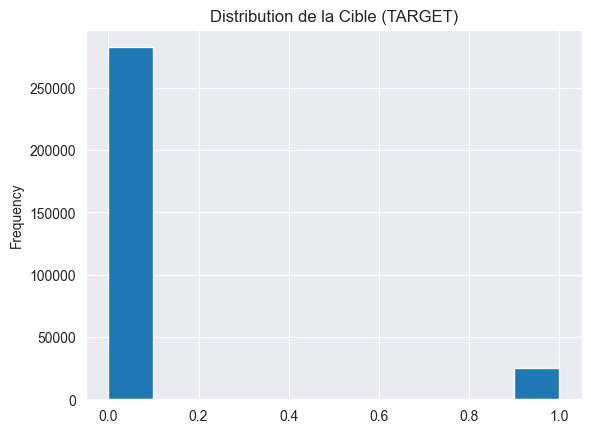


--- Analyse des valeurs manquantes ---
Le dataframe a 122 colonnes.
Il y a 67 colonnes qui ont des valeurs manquantes.
                          Missing Values  % of Total Values
COMMONAREA_MEDI                   214865               69.9
COMMONAREA_MODE                   214865               69.9
COMMONAREA_AVG                    214865               69.9
NONLIVINGAPARTMENTS_MODE          213514               69.4
NONLIVINGAPARTMENTS_MEDI          213514               69.4
NONLIVINGAPARTMENTS_AVG           213514               69.4
FONDKAPREMONT_MODE                210295               68.4
LIVINGAPARTMENTS_AVG              210199               68.4
LIVINGAPARTMENTS_MEDI             210199               68.4
LIVINGAPARTMENTS_MODE             210199               68.4
FLOORSMIN_MEDI                    208642               67.8
FLOORSMIN_MODE                    208642               67.8
FLOORSMIN_AVG                     208642               67.8
YEARS_BUILD_MODE                  204488

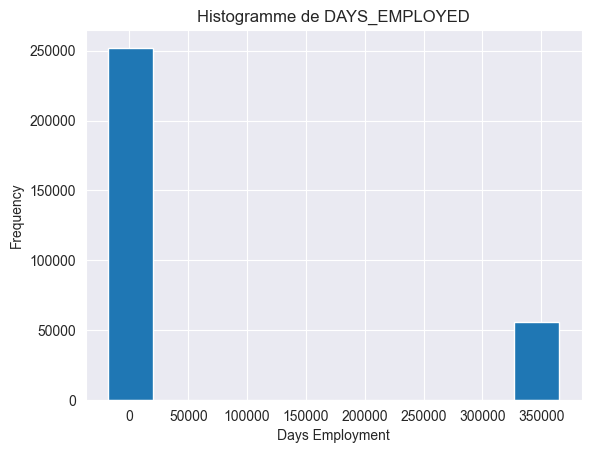

Les non-anomalies ont un taux de défaut de: 8.66%
Les anomalies ont un taux de défaut de: 5.40%
Il y a 55374 jours d'emploi anormaux.

--- Corrélations les plus positives avec la cible ---
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

--- Corrélations les plus négatives avec la cible ---
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLO

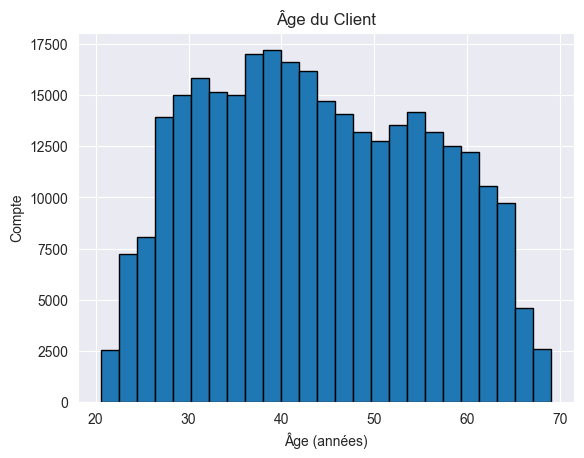

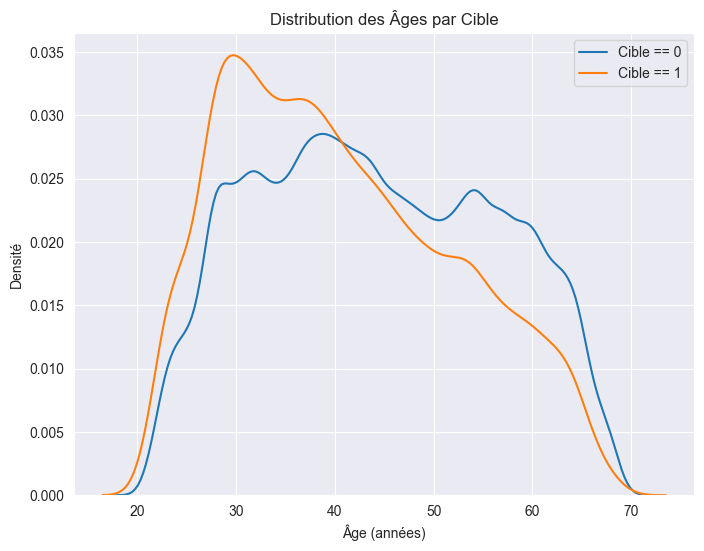


--- Analyse des features EXT_SOURCE ---
                TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919    0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846   -0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167   -0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000   -0.205478
DAYS_BIRTH    0.078239     -0.600610     -0.091996     -0.205478    1.000000


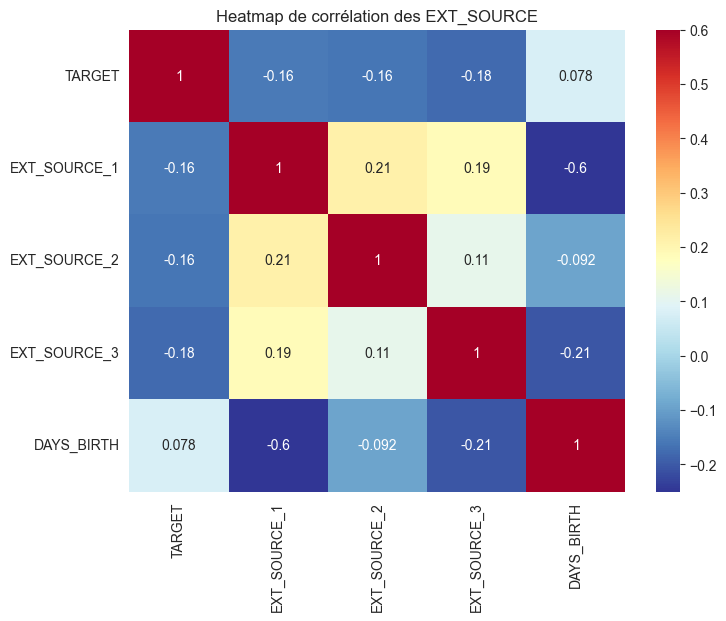

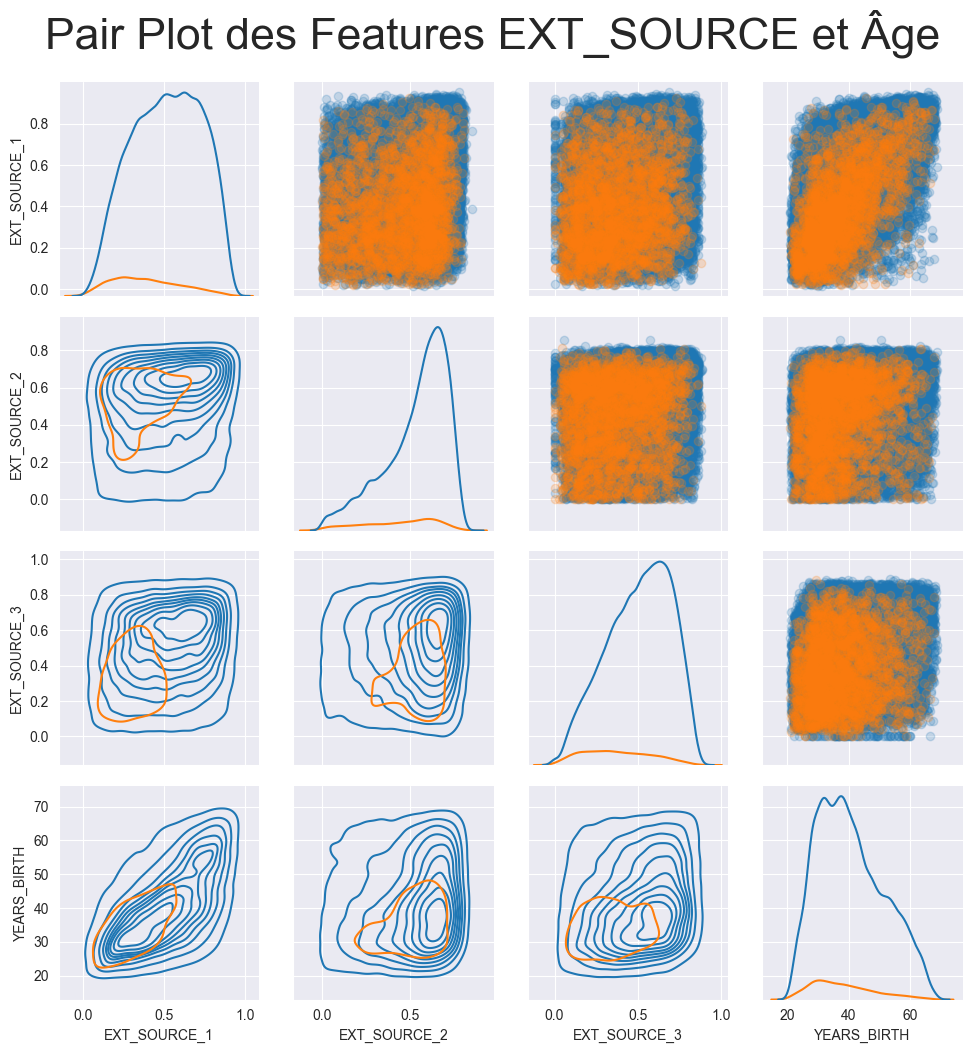

In [2]:
# ====================================================================
# ANALYSE EXPLORATOIRE DES DONNÉES (EDA)
# S'exécute sur les données brutes pour comprendre leurs caractéristiques.
# ====================================================================

# Chargement des données d'entraînement pour l'analyse
app_train = pd.read_csv('../data/application_train.csv')
print('Shape des données d\'entraînement: ', app_train.shape)

# --- 1. Analyse de la variable cible ---
print("\n--- Analyse de la variable cible ---")
print(app_train['TARGET'].value_counts())
app_train['TARGET'].astype(int).plot.hist(title='Distribution de la Cible (TARGET)');
plt.show()

# --- 2. Analyse des valeurs manquantes ---
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'}
    )
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0
    ].sort_values('% of Total Values', ascending=False).round(1)
    print(f"\n--- Analyse des valeurs manquantes ---")
    print(f"Le dataframe a {df.shape[1]} colonnes.")
    print(f"Il y a {mis_val_table_ren_columns.shape[0]} colonnes qui ont des valeurs manquantes.")
    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
print(missing_values.head(20))

# --- 3. Analyse des types de colonnes ---
print("\n--- Analyse des types de colonnes ---")
print(app_train.dtypes.value_counts())
print("\nNombre de classes uniques dans chaque colonne 'object':")
print(app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0))

# --- 4. Analyse des anomalies ---
print("\n--- Analyse des anomalies (DAYS_EMPLOYED) ---")
print(app_train['DAYS_EMPLOYED'].describe())
app_train['DAYS_EMPLOYED'].plot.hist(title='Histogramme de DAYS_EMPLOYED');
plt.xlabel('Days Employment');
plt.show()

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print(f"Les non-anomalies ont un taux de défaut de: {100 * non_anom['TARGET'].mean():.2f}%")
print(f"Les anomalies ont un taux de défaut de: {100 * anom['TARGET'].mean():.2f}%")
print(f"Il y a {len(anom)} jours d'emploi anormaux.")

# --- 5. Analyse des corrélations ---
correlations = app_train.corr(numeric_only=True)['TARGET'].sort_values()
print("\n--- Corrélations les plus positives avec la cible ---")
print(correlations.tail(15))
print("\n--- Corrélations les plus négatives avec la cible ---")
print(correlations.head(15))

# --- 6. Analyse approfondie de l'âge (DAYS_BIRTH) ---
print("\n--- Analyse de l'âge du client ---")
(app_train['DAYS_BIRTH'] / -365).describe()
plt.hist((app_train['DAYS_BIRTH'] / -365), edgecolor='k', bins=25)
plt.title('Âge du Client'); plt.xlabel('Âge (années)'); plt.ylabel('Compte');
plt.show()

plt.figure(figsize=(8, 6))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label='Cible == 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label='Cible == 1')
plt.xlabel('Âge (années)'); plt.ylabel('Densité'); plt.title('Distribution des Âges par Cible');
plt.legend();
plt.show()

# --- 7. Analyse approfondie des features EXT_SOURCE ---
print("\n--- Analyse des features EXT_SOURCE ---")
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
print(ext_data_corrs)

plt.figure(figsize=(8, 6))
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Heatmap de corrélation des EXT_SOURCE');
plt.show()

# Création du PairGrid pour visualiser les relations

plot_data = ext_data.drop(columns=['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = app_train['DAYS_BIRTH'] / -365
plot_data = plot_data.dropna().loc[:100000, :]

grid = sns.PairGrid(data=plot_data, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])
grid.map_upper(plt.scatter, alpha=0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r);
plt.suptitle('Pair Plot des Features EXT_SOURCE et Âge', size=32, y=1.05);
plt.show()

In [3]:
# ====================================================================
# 2. FONCTIONS DE PRÉPARATION DES DONNÉES
# ====================================================================

def application_train_test(nan_as_category=False):
    """Prétraitement de application_train.csv et application_test.csv."""
    df = pd.read_csv('../data/application_train.csv')
    test_df = pd.read_csv('../data/application_test.csv')
    print(f"Échantillons d'entraînement: {len(df)}, Échantillons de test: {len(test_df)}")
    df = pd.concat([df, test_df], ignore_index=True)

    # Nettoyage
    df = df[df['CODE_GENDER'] != 'XNA']
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    # Feature Engineering
    df['DAYS_EMPLOYED_ANOM'] = (df['DAYS_EMPLOYED'] == 365243)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Encodage
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    del test_df
    gc.collect()
    return df

def bureau_and_balance(nan_as_category=True):
    """Prétraitement de bureau.csv et bureau_balance.csv."""
    bureau = pd.read_csv('../data/bureau.csv')
    bb = pd.read_csv('../data/bureau_balance.csv')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'], 'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'], 'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'], 'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'], 'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'], 'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'], 'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'], 'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    del active, active_agg, closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

def previous_applications(nan_as_category=True):
    """Prétraitement de previous_application.csv."""
    prev = pd.read_csv('../data/previous_application.csv')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'], 'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'], 'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'], 'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'], 'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'], 'CNT_PAYMENT': ['mean', 'sum'],
    }
    cat_aggregations = {cat: ['mean'] for cat in cat_cols}

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

def pos_cash(nan_as_category=True):
    """Prétraitement de POS_CASH_balance.csv."""
    pos = pd.read_csv('../data/POS_CASH_balance.csv')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'], 'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols: aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

def installments_payments(nan_as_category=True):
    """Prétraitement de installments_payments.csv."""
    ins = pd.read_csv('../data/installments_payments.csv')
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'], 'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'], 'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'], 'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'], 'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols: aggregations[cat] = ['mean']

    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

def credit_card_balance(nan_as_category=True):
    """Prétraitement de credit_card_balance.csv."""
    cc = pd.read_csv('../data/credit_card_balance.csv')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # Définir explicitement les agrégations pour éviter les problèmes de type
    aggregations = {}
    # Pour les colonnes one-hot, la moyenne donne la proportion/fréquence
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    # Pour les colonnes numériques, on garde les agrégations multiples
    numeric_cols = [col for col in cc.columns if col not in cat_cols + ['SK_ID_CURR', 'SK_ID_PREV']]
    for num in numeric_cols:
        aggregations[num] = ['min', 'max', 'mean', 'sum', 'var']

    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(aggregations)
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Compter le nombre de lignes de carte de crédit par client
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    del cc
    gc.collect()
    return cc_agg

def polynomial_features(df):
    """Crée des features polynomiales à partir des colonnes spécifiées."""
    poly_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
    imputer = SimpleImputer(strategy='median')
    poly_data = df[poly_cols].copy().replace([np.inf, -np.inf], np.nan)
    poly_data = imputer.fit_transform(poly_data)

    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly.fit(poly_data)

    poly_features = poly.transform(poly_data)
    poly_feature_names = poly.get_feature_names_out(poly_cols)

    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

    poly_df = poly_df.drop(columns=poly_cols)

    # Fusionner les nouvelles features
    df = df.join(poly_df)

    return df

In [4]:
# ====================================================================
# 3. ENREGISTREMENT DATAFRAME
# ====================================================================

def run_full_preprocessing():
    with timer("Prétraitement de application_train_test"):
        df = application_train_test()
    with timer("Prétraitement de bureau & balance"):
        bureau = bureau_and_balance()
        print("Shape de Bureau:", bureau.shape)
        df = df.merge(bureau, on='SK_ID_CURR', how='left')
        del bureau
        gc.collect()
    with timer("Prétraitement des demandes précédentes"):
        prev = previous_applications()
        print("Shape des demandes précédentes:", prev.shape)
        df = df.merge(prev, on='SK_ID_CURR', how='left')
        del prev
        gc.collect()
    with timer("Prétraitement de POS-CASH balance"):
        pos = pos_cash()
        print("Shape de POS-CASH balance:", pos.shape)
        df = df.merge(pos, on='SK_ID_CURR', how='left')
        del pos
        gc.collect()
    with timer("Prétraitement des paiements d'échéances"):
        ins = installments_payments()
        print("Shape des paiements d'échéances:", ins.shape)
        df = df.merge(ins, on='SK_ID_CURR', how='left')
        del ins
        gc.collect()
    with timer("Prétraitement de Credit Card Balance"):
        cc = credit_card_balance()
        print("Shape de Credit Card Balance:", cc.shape)
        df = df.merge(cc, on='SK_ID_CURR', how='left')
        del cc
        gc.collect()
    with timer("Création des features polynomiales"):
        df = polynomial_features(df)
        print("Shape après features polynomiales:", df.shape)

    # Remplacer les valeurs infinies par NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    # Remplacer les caractères spéciaux dans les noms de colonnes
    df = df.rename(columns=lambda col: re.sub('[^A-Za-z0-9_]+', '_', col))

    # Sauvegarde du DataFrame final
    print("Sauvegarde du DataFrame final dans 'final_dataset.parquet'")
    df.to_parquet('final_dataset.parquet', index=False)

    return df

if __name__ == "__main__":
    with timer("Exécution du prétraitement complet"):
        # run_full_preprocessing()
        pass

Exécution du prétraitement complet - fait en 0s
